TRAIN AUGMENTATION BY 90 DEGREE FLIPS

In [3]:
import numpy as np
import cv2
import pandas as pd
import os.path as osp
import cPickle as pkl

In [2]:
import cPickle
with open('OIRDS_train.pkl', 'rb') as f:
    train_set = cPickle.load(f)

In [ ]:
import numpy as np
import cv2

rows = 256
cols = rows
angle = 90

M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1).astype(np.int32)
print(M.dtype)
arr = np.array([[3, 0], [4, 2], [3, 4], [1, 5], [0, 3], [1, 1]], dtype=np.float32)
arr = np.hstack([arr, np.ones((arr.shape[0], 1),dtype=np.float32)])
print(arr.dtype)
print(np.dot(M,arr.T).T.astype(np.int32))

In [60]:
def rotate_polygon(polygon, im_path, angle):
    im = cv2.imread(im_path)
    cols = im.shape[1]
    rows = im.shape[0]
    
    M = cv2.getRotationMatrix2D((cols/2.,rows/2.),angle,1)
    polygon_affn = np.hstack([polygon, np.ones((polygon.shape[0], 1))])
    # rotate
    unaligned = np.dot(M, polygon_affn.T).T
    # align it back to axis with stupid trick
    offset_x = rows-cols / 2.
    offset_y = cols-rows / 2.
    unaligned[:, 0] += offset_x
    unaligned[:, 1] += offset_y
    rotated_poly = unaligned
    return rotated_poly.astype(np.int32)

# propogate error through return value
def make_int(lst):
    if type(lst) == list:
        for i in xrange(len(lst)):
            if type(lst[i]) == unicode:
                if lst[i] == u'': return None
                lst[i] = int(lst[i])
            elif type(lst[i]) == list:
                out = make_int(lst[i])
                if out is None:
                    return None
    return lst

def parse_string_poly(p):
    row_delim = ';'
    col_delim = ' '
    # remove array start-finish delims
    rows = p[1:-1].split(row_delim)
    str_poly = [row.split(col_delim) for row in rows]
    int_poly = make_int(str_poly)
    if int_poly is None:
        return None
    else:
        return np.array(int_poly)

def get_bbox(poly_points):
    xmin, ymin = np.min(poly_points[:,0]), np.min(poly_points[:,1])
    xmax, ymax = np.max(poly_points[:,0]), np.max(poly_points[:,1])
    return [xmin, ymin, xmax, ymax]

In [61]:
root = '/media/data/lioruzan/OIRDS_v1_0'
for angle in [90, 180, 270]:
    for i in xrange(1,21):
        dsname = 'DataSet{}'.format(i)
        ds = pd.read_excel(dsname + '.xls')
        dsdic = {}
        for j in xrange(len(ds)):
            ser = ds.loc[j]
            img_name = osp.join('DataSet_{}'.format(i), ser['Image Name'].replace('.tif', '.png'))
            if img_name not in dsdic: dsdic[img_name] = []
            # stupid parse stupid polygon
            poly_str = ser['Intersection Polygon']
            poly_arr = parse_string_poly(poly_str)
            if poly_arr is None: continue
            # change to 0-based coordinates
            poly_arr = poly_arr - 1
            # rotate polygon
            rotated_polygon = rotate_polygon(poly_arr, 
                                             osp.join(root,img_name), 
                                             angle)
            bbox = get_bbox(rotated_polygon)
            if bbox[0] < 0 or bbox[1] < 0:
                print(img_name, poly_arr, rotated_polygon, angle, bbox)
                raise Exception
            dsdic[img_name].append(bbox)

        for k in dsdic.keys():
            if len(dsdic[k]) == 0: 
                del dsdic[k]
                continue
            dsdic[k] = np.vstack(dsdic[k])

        with open(dsname + '_{}.pkl'.format(angle), 'wb') as f:
            cPickle.dump(dsdic, f)

SOME TESTS FOR SANITY CHECKING AND STATS

In [68]:
final_ds = {}
for i in xrange(1,21):
    dsname = 'DataSet{}.pkl'.format(i)
    with open(dsname, 'rb') as f:
        cur_ds = cPickle.load(f)
    pics = list(cur_ds.keys())
    pics.remove(u'basedir')
    for pic in pics:
        new_pic = osp.join(cur_ds['basedir'], pic)
        final_ds[new_pic] = np.array(cur_ds[pic], dtype=np.int32)
count=0
for k,v in final_ds.iteritems():
    print(k,v)
    count += len(v)
print(len(final_ds))
print('count=',count)

(u'DataSet_15/73840604_3073_1537_3329_1793.png', array([[ 72, 205, 102, 217],
       [ 75, 227, 103, 241],
       [179, 206, 189, 230]], dtype=int32))
(u'DataSet_7/46946744_257_3841_513_4097.png', array([[ 16, 123,  48, 143],
       [ 42, 195,  63, 227]], dtype=int32))
(u'DataSet_17/57196288_5633_1793_5889_2049.png', array([[ 81, 182, 108, 207],
       [126, 137, 146, 169],
       [170, 166, 185, 197]], dtype=int32))
(u'DataSet_9/27761951_5377_769_5633_1025.png', array([[  6,  85,  20, 117],
       [ 31,  92,  44, 122]], dtype=int32))
(u'DataSet_13/83232319_257_2561_513_2817.png', array([[157, 107, 171, 137]], dtype=int32))
(u'DataSet_10/45922004_3073_2305_3329_2561.png', array([[ 93, 109, 126, 124],
       [143, 142, 154, 173],
       [133, 106, 168, 120],
       [164, 126, 179, 161]], dtype=int32))
(u'DataSet_7/46946744_2561_4865_2817_5121.png', array([[139,  10, 164,  46],
       [210, 140, 242, 162],
       [226, 109, 248, 138]], dtype=int32))
(u'DataSet_18/18464358_3073_2817_3329_

In [69]:
rotated_ds = {}
for i in xrange(1,21):
    dsname = 'DataSet{}_90.pkl'.format(i)
    with open(dsname, 'rb') as f:
        cur_ds = cPickle.load(f)
    pics = list(cur_ds.keys())
    for pic in pics:
        rotated_ds[pic] = cur_ds[pic]

count=0
for k,v in rotated_ds.iteritems():
    print(k,v)
    count += len(v)
print(len(rotated_ds))
print('count=',count)

(u'DataSet_15/73840604_3073_1537_3329_1793.png', array([[333, 283, 345, 313],
       [355, 282, 369, 310],
       [334, 196, 358, 206]], dtype=int32))
(u'DataSet_7/46946744_257_3841_513_4097.png', array([[251, 337, 271, 369],
       [323, 322, 355, 343]], dtype=int32))
(u'DataSet_17/57196288_5633_1793_5889_2049.png', array([[310, 277, 335, 304],
       [265, 239, 297, 259],
       [294, 200, 325, 215]], dtype=int32))
(u'DataSet_9/27761951_5377_769_5633_1025.png', array([[213, 365, 245, 379],
       [220, 341, 250, 354]], dtype=int32))
(u'DataSet_13/83232319_257_2561_513_2817.png', array([[235, 214, 265, 228]], dtype=int32))
(u'DataSet_10/45922004_3073_2305_3329_2561.png', array([[237, 259, 252, 292],
       [270, 231, 301, 242],
       [234, 217, 248, 252],
       [254, 206, 289, 221]], dtype=int32))
(u'DataSet_7/46946744_2561_4865_2817_5121.png', array([[138, 221, 174, 246],
       [268, 143, 290, 175],
       [237, 137, 266, 159]], dtype=int32))
(u'DataSet_18/18464358_3073_2817_3329_

In [30]:
with open('OIRDS_bbox.pkl', 'rb') as f:
    t = cPickle.load(f)
len(t.keys())

908

VISUALISE BBOXES

/media/data/lioruzan/OIRDS_v1_0/DataSet_2/87562818_4_9.png
/media/data/lioruzan/OIRDS_v1_0/DataSet_2/25302842_4_5.png
/media/data/lioruzan/OIRDS_v1_0/DataSet_2/32066967_20_5.png
/media/data/lioruzan/OIRDS_v1_0/DataSet_2/77151517_2_3.png
/media/data/lioruzan/OIRDS_v1_0/DataSet_2/25302842_1_5.png
/media/data/lioruzan/OIRDS_v1_0/DataSet_2/77151517_2_1.png
/media/data/lioruzan/OIRDS_v1_0/DataSet_2/87562818_1_17.png
/media/data/lioruzan/OIRDS_v1_0/DataSet_2/46532678_2_8.png


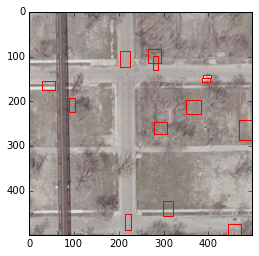

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

root = '/media/data/lioruzan/OIRDS_v1_0'
with open('DataSet2.pkl','rb') as f:
    ds = pkl.load(f)
pics = list(ds.keys())
pics.remove(u'basedir')
assert(type(pics)==list)

count=0
for pic in pics:
    count += 1
    if count != 6: continue
    pic_path = osp.join(root, ds['basedir'], pic)
    print(pic_path)
    im = plt.imread(pic_path)
    plt.imshow(im)
    currentAxis = plt.gca()
    # each row is a bbox
    for j in xrange(len(ds[pic])):
        det = ds[pic][j]
        coords = (det[0], det[1]), det[2]-det[0], det[3]-det[1]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='r', linewidth=1))
    
